# Logistic regression with $\ell_1$ regularization

In this example, we use CVXPY to train a logistic regression classifier with $\ell_1$ regularization. We are given data $(x_i,y_i)$, $i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{0, 1\}$ are associated boolean classes.

Our goal is to construct a linear classifier $\hat y = \mathbb{1}[\beta^T x > 0]$, which is $1$ when $\beta^T x$ is positive and $0$ otherwise.  We model the posterior probabilities of the classes given the data linearly, with

$$
\log \frac{\mathrm{Pr} (Y=1 \mid X = x)}{\mathrm{Pr} (Y=0 \mid X = x)} = \beta^T x.
$$

This implies that

$$
\mathrm{Pr} (Y=1 \mid X = x) = \frac{\exp(\beta^T x)}{1 + \exp(\beta^T x)}, \quad
\mathrm{Pr} (Y=0 \mid X = x) = \frac{1}{1 + \exp(\beta^T x)}.
$$

We fit $\beta$ by maximizing the log-likelihood of the data, under a constraint that  $ \|\beta\|_1 \leq \lambda$ with $\lambda > 0$:

$$
\max_{\beta}  \ell(\beta) = \sum_{i=1}^{m} y_i \beta^T x_i - \log(1 + \exp (\beta^T x_i)) ~~\textrm{subject to}~~ \| \beta \|_1 \leq \lambda.
$$

Because $\ell$ is a concave function of $\beta$, this is a convex optimization problem.



In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In the following code we generate data with $n=50$ features by randomly choosing $x_i$ and supplying a sparse $\beta_{\mathrm{true}} \in {\bf R}^n$.
We then set $y_i = \mathbb{1}[\beta_{\mathrm{true}}^T x_i + z_i > 0]$, where the $z_i$ are i.i.d. normal random variables.
We divide the data into training and test sets with $m=500$ examples each.

In [2]:
np.random.seed(431)
n = 50
m = 500
def sigmoid(z):
  return 1/(1 + np.exp(-z))

beta_true = np.array([1, 0.5, -0.5, 0.5, -0.5] + [0]*(n - 5))
X = (np.random.random((m, n)) - 0.5)*10
Y = np.round(sigmoid(X @ beta_true + np.random.randn(m)*0.5))

X_test = (np.random.random((2*m, n)) - 0.5)*10
Y_test = np.round(sigmoid(X_test @ beta_true + np.random.randn(2*m)*0.5))

We next formulate the optimization problem using CVXPY. (Your code goes here)

In [3]:
## Your code goes here
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
log_likelihood = cp.sum(
    cp.multiply(Y, X @ beta) - cp.logistic(X @ beta)
)

objective = cp.Maximize(log_likelihood/m)
constraint = [cp.norm(beta, 1) <= lambd]
problem = cp.Problem(objective, constraint)


We solve the optimization problem for a range of $\lambda$ to compute a trade-off curve.
We then plot the train and test error over the trade-off curve.
A reasonable choice of $\lambda$ is the value that minimizes the test error.

In [4]:
def error(scores, labels):
  scores[scores > 0] = 1
  scores[scores <= 0] = 0
  return np.sum(np.abs(scores - labels)) / float(np.size(labels))

In [5]:
trials = 30
train_error = np.zeros(trials)
test_error = np.zeros(trials)
lambda_vals = np.linspace(1, 4, trials)
print(lambda_vals)
beta_vals = []
for i in range(trials):
    lambd.value = lambda_vals[i]
    problem.solve()
    train_error[i] = error( (X @ beta).value, Y)
    test_error[i] = error( (X_test @ beta).value, Y_test)
    beta_vals.append(beta.value)

[1.         1.10344828 1.20689655 1.31034483 1.4137931  1.51724138
 1.62068966 1.72413793 1.82758621 1.93103448 2.03448276 2.13793103
 2.24137931 2.34482759 2.44827586 2.55172414 2.65517241 2.75862069
 2.86206897 2.96551724 3.06896552 3.17241379 3.27586207 3.37931034
 3.48275862 3.5862069  3.68965517 3.79310345 3.89655172 4.        ]


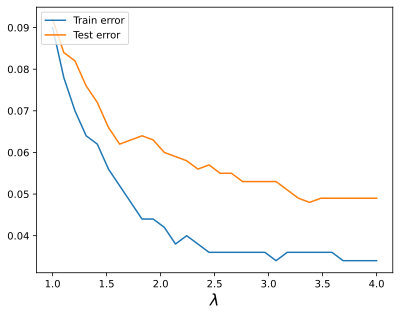

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
# plt.xscale("log")
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

We plot the true $\beta$ versus reconstructed $\beta$, as chosen to minimize error on the test set. The non-zero coefficients are reconstructed with good accuracy. There are a few values in the reconstructed $\beta$ that are non-zero but should be zero.

the first 10 entries of the learned beta are [ 1.14155664e+00  5.62931248e-01 -5.08172692e-01  6.02838890e-01
 -5.15841725e-01 -6.86371077e-13  2.96787511e-11 -1.15876524e-11
  7.40041091e-12  3.26687089e-11]
the error of the estimated beta is 0.18922484967150469


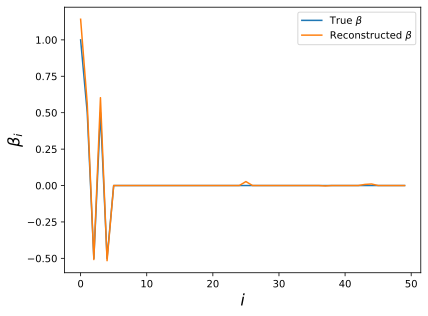

In [8]:
idx = np.argmin(test_error)
plt.plot(beta_true, label=r"True $\beta$")
plt.plot(beta_vals[idx], label=r"Reconstructed $\beta$")
plt.xlabel(r"$i$", fontsize=16)
plt.ylabel(r"$\beta_i$", fontsize=16)
plt.legend(loc="upper right")
print("the first 10 entries of the learned beta are", beta_vals[idx][0:10])
print("the error of the estimated beta is", np.linalg.norm(beta_true - beta_vals[idx]))

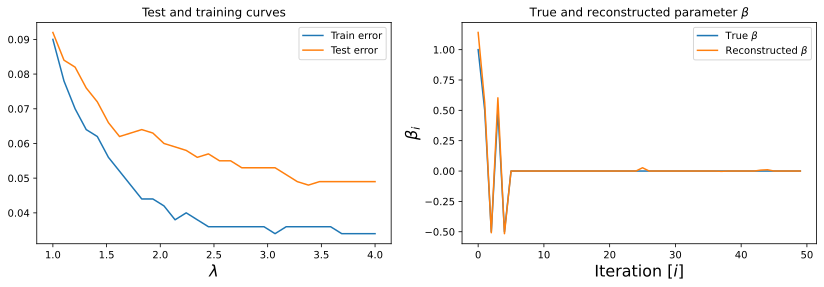

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(lambda_vals, train_error, label="Train error")
ax[0].plot(lambda_vals, test_error, label="Test error")
ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"$\lambda$", fontsize=16)
ax[0].set_title("Test and training curves")

ax[1].plot(beta_true, label=r"True $\beta$")
ax[1].plot(beta_vals[idx], label=r"Reconstructed $\beta$")
ax[1].set_xlabel(r"Iteration $[i]$", fontsize=16)
ax[1].set_ylabel(r"$\beta_i$", fontsize=16)
ax[1].legend(loc="upper right")
ax[1].set_title(r"True and reconstructed parameter $\beta$")

fig.savefig("problem8.pdf", bbox_inches="tight")